<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/Colab_Cloud_Statistics_S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads the odc-colab Python module and runs it to setup ODC.

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

Downloads an existing index and populates the new ODC environment with it.

In [ ]:
from odc_colab import populate_db
populate_db()

# Sentinel-2 Cloud Statistics
This notebook explores sample Sentinel-2 data from Google Earth Engine which has been indexed to work with the Open Data Cube. The data is used to calculate cloud statistics for selected regions. This is valuable information for performing analysis. For example, if there are extensive clouds for a season it may significantly impact the mosaic product or index values. Another example is that a user may want to find a single date when there are few clouds to assess land features.

In [ ]:
# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Cloud_Statistics')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Select a Product and Platform
# This data is indexed from Google Earth Engine data sources

product = "s2_google"
platform = "Sentinel-2A"

In [5]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Mombasa, Kenya
lat_long = (-4.03, 39.62)
box_size_deg = 0.20

# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

# Time Period
time_extents = ('2020-01-01', '2020-03-01')

In [6]:
# Display the analysis region
# Click on the plot to get Lat-Lon coordinates to adjust the region
# Zoom in/out on the plot to move around the globe for other regions

display_map(latitude,longitude)

## Calculate cloud coverage percentage for each pixel 

In [7]:
# Define a function to build a cloud coverage table

def build_cloud_coverage_table_sentinel(product=None,
                                        platform=None,
                                        latitude=None,
                                        longitude=None,
                                        time=None,
                                        dc=None,
                                        extra_band='green'):
    
    if product   is None: raise Exception("product argument is required")
    if platform  is None: raise Exception("platform argument is required")
    if latitude  is None: raise Exception("latitude argument is required")
    if longitude is None: raise Exception("longitude argument is required")
    
    load_params = dict(product = product,
                       platform = platform,
                       latitude = latitude,
                       longitude = longitude,
                       group_by='solar_day',
                       measurements = [extra_band, 'scl'])
    
    if time is not None: 
        load_params["time"] = time
        
    geo_data = dc.load(**load_params)
    
    times = list(geo_data.time.values)
    scene_slice_list = list(map(lambda t: geo_data.sel(time = t), times))
   
    clean_mask_list = (geo_data.scl.values != 0) & (geo_data.scl.values != 1) & \
                      (geo_data.scl.values != 3) & (geo_data.scl.values != 8) & \
                      (geo_data.scl.values != 9) & (geo_data.scl.values != 10)
    
    percentage_list = [clean_mask.mean()*100 for clean_mask in clean_mask_list]
    clean_pixel_count_list = list(map(np.sum, clean_mask_list))
    
    data = {"times": times,
            # "clean_percentage" is the percent of pixels that are not no_data which are clear.
            "clean_percentage": percentage_list,
            "clean_count": clean_pixel_count_list }
    
    return geo_data, pd.DataFrame(data=data, columns = ["times", "clean_percentage", "clean_count"])

In [8]:
# Load the data and calculate the cloud coverage for each time slice
sentinel_dataset, coverage_table = build_cloud_coverage_table_sentinel(product = product,
                                                                       platform = platform,
                                                                       latitude = latitude,
                                                                       longitude = longitude,
                                                                       time = time_extents,
                                                                       dc = dc,
                                                                       extra_band = 'green')

## Create a table of cloud coverage percentage for each date

In [9]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,times,clean_percentage,clean_count
0,2020-01-06 07:50:58.807,62.640102,3108049
1,2020-01-11 07:50:58.270,65.222272,3236170
2,2020-01-16 07:50:58.036,31.920413,1583813
3,2020-01-21 07:50:57.535,94.326666,4680259
4,2020-01-26 07:50:57.161,1.482902,73578
5,2020-01-31 07:50:56.325,2.695437,133741
6,2020-02-05 07:50:57.723,40.788906,2023846
7,2020-02-10 07:50:56.462,65.355975,3242804
8,2020-02-15 07:50:59.561,63.003884,3126099
9,2020-02-20 07:50:52.189,0.019711,978


## Create a plot of cloud coverage percentage for each date

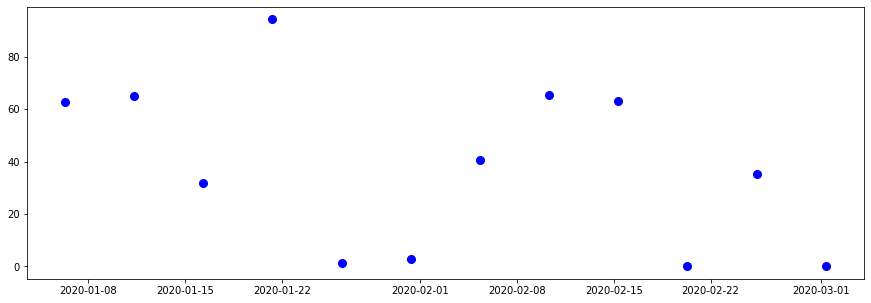

In [10]:
plt.figure(figsize = (15,5))
plt.plot(coverage_table["times"].values, coverage_table["clean_percentage"].values, 'bo', markersize=8)
plt.show()

## Review an RGB scene for a selected time slice

In [11]:
# Load the data to create an RGB image
sentinel_dataset = dc.load(latitude = latitude,
                           longitude = longitude,
                           platform = platform,
                           time = time_extents,
                           product = product,
                           group_by='solar_day',
                           measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']) 

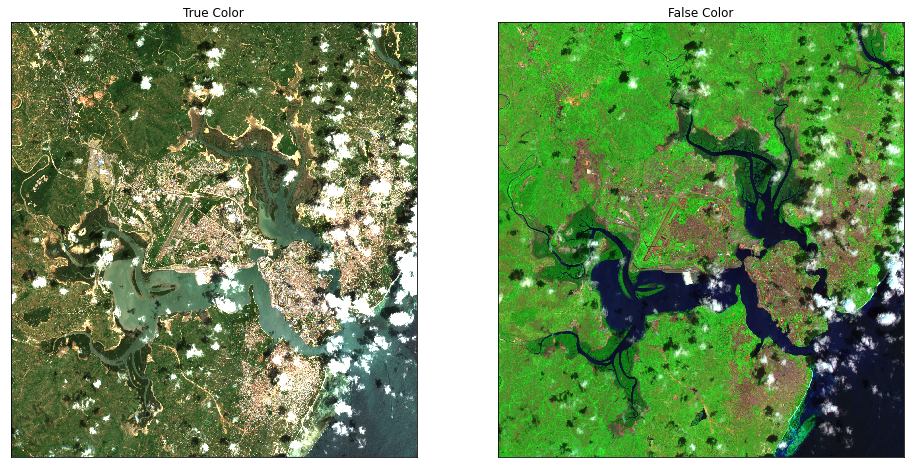

In [12]:
# Select one of the time slices and create an RGB image. 
# Time slices are numbered from 0 to x and shown in the table above
# Review the clean_percentage values above to select scenes with few clouds
# Clouds will be visible in WHITE for an RGB image

# RGB image options
# True-Color RGB = Red, Green, Blue
# False Color RGB (Mosaic) = SWIR2, NIR, Green

slice = 3  # select the time slice number here

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
true_rgb = sentinel_dataset.isel(time=slice)[['red', 'green', 'blue']].to_array()
false_rgb = sentinel_dataset.isel(time=slice)[['swir2', 'nir', 'green']].to_array()
true_rgb.plot.imshow(ax=ax[0], vmin=0, vmax=2000)
false_rgb.plot.imshow(ax=ax[1], vmin=0, vmax=5000)
ax[0].set_title('True Color'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('False Color'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()